## Web Crawling
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crawling Naver Stock Data
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [1]:
import warnings
warnings.filterwarnings('ignore') # 경고 문구 출력 x
import pandas as pd
import requests

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [2]:
page_size, page = 60, 1
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}'
url

'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=60&page=1'

#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [3]:
response = requests.get(url)
response

<Response [200]>

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [4]:
response.text[:50] # datatype : str

'[{"localTradedAt":"2024-03-07","closePrice":"2,647'

In [5]:
type(response.json())

list

In [9]:
data = response.json() # str > list, dict
data[:3]

[{'localTradedAt': '2024-03-07',
  'closePrice': '2,647.62',
  'compareToPreviousClosePrice': '6.13',
  'compareToPreviousPrice': {'code': '2', 'text': '상승', 'name': 'RISING'},
  'fluctuationsRatio': '0.23',
  'openPrice': '2,653.98',
  'highPrice': '2,660.26',
  'lowPrice': '2,633.57'},
 {'localTradedAt': '2024-03-06',
  'closePrice': '2,641.49',
  'compareToPreviousClosePrice': '-7.91',
  'compareToPreviousPrice': {'code': '5', 'text': '하락', 'name': 'FALLING'},
  'fluctuationsRatio': '-0.30',
  'openPrice': '2,638.84',
  'highPrice': '2,649.78',
  'lowPrice': '2,630.16'},
 {'localTradedAt': '2024-03-05',
  'closePrice': '2,649.40',
  'compareToPreviousClosePrice': '-24.87',
  'compareToPreviousPrice': {'code': '5', 'text': '하락', 'name': 'FALLING'},
  'fluctuationsRatio': '-0.93',
  'openPrice': '2,660.80',
  'highPrice': '2,684.83',
  'lowPrice': '2,649.35'}]

In [10]:
df = pd.DataFrame(data) # list, dict > DataFrame
columns = ['localTradedAt', 'closePrice']
df = df[columns]
df.head()

,localTradedAt,closePrice
0,2024-03-07,"2,647.62"
1,2024-03-06,"2,641.49"
2,2024-03-05,"2,649.40"
3,2024-03-04,"2,674.27"
4,2024-02-29,"2,642.36"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   localTradedAt  60 non-null     object
 1   closePrice     60 non-null     object
dtypes: object(2)
memory usage: 1.1+ KB


#### 4. 함수로 만들기

In [12]:
def stock_price(code='KOSPI', page_size=60, page=1):
    
    # 1. 웹 서비스 분석 > URL
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}'

    # 2. request(URL) > response(JSON) : JSON(str)
    response = requests.get(url)
    
    # 3. JSON(str) > list, dict > DataFrame : Data
    data = response.json()
    df = pd.DataFrame(data)
    return df[['localTradedAt', 'closePrice']]

In [13]:
df = stock_price()
df.tail(2)

,localTradedAt,closePrice
58,2023-12-08,"2,517.85"
59,2023-12-07,"2,492.07"


In [14]:
df = stock_price(code='KOSDAQ')
df.tail(2)

,localTradedAt,closePrice
58,2023-12-08,830.37
59,2023-12-07,813.20


#### 5. 원달러 환율 데이터 수집 : 실습

In [23]:
def exchange_rate(code="FX_USDKRW", page=1, page_size=60):
    # 1. 웹 서비스 분석 > URL
    url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&reutersCode={code}&pageSize={page_size}'

    # 2. request(URL) > response(JSON) : JSON(str)
    response = requests.get(url)   

    # 3. JSON(str) > list, dict > DataFrame : Data
    data = response.json()['result']
    return pd.DataFrame(data)[['localTradedAt','closePrice']]


#### 6. 시각화

In [17]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# 데이터 수집
page_size = 60
kospi_df = stock_price(code="KOSPI", page_size=page_size)
kosdaq_df = stock_price(code="KOSDAQ", page_size=page_size)
usd_df = exchange_rate(code="FX_USDKRW", page_size=page_size)

In [34]:
# 데이터 전처리 1: 데이터 타입 변경
print(kospi_df.dtypes)
kospi_df['kospi'] = kospi_df['closePrice'].apply(
    lambda data: float(data.replace(",", ""))
)
kospi_df = kospi_df.drop(columns=['closePrice'])
print(kospi_df.dtypes)

localTradedAt    object
closePrice       object
dtype: object
localTradedAt     object
kospi            float64
dtype: object


In [35]:
kosdaq_df['kosdaq'] = kosdaq_df['closePrice'].apply(
    lambda data: float(data.replace(",", ""))
)
kosdaq_df = kosdaq_df.drop(columns=['closePrice'])

In [36]:
usd_df['usd'] = usd_df['closePrice'].apply(
    lambda data: float(data.replace(",", ""))
)
usd_df = usd_df.drop(columns=['closePrice'])

In [37]:
# 데이터 전처리 2 : 날짜 데이터 맞추기 -> merge 
merge_df_1 = pd.merge(kospi_df, kosdaq_df, on="localTradedAt")
merge_df_2 = pd.merge(merge_df_1, usd_df, on="localTradedAt")
merge_df = merge_df_2.copy()
merge_df.tail(2)

,localTradedAt,kospi,kosdaq,usd
57,2023-12-11,2525.36,835.25,1321.0
58,2023-12-08,2517.85,830.37,1320.0


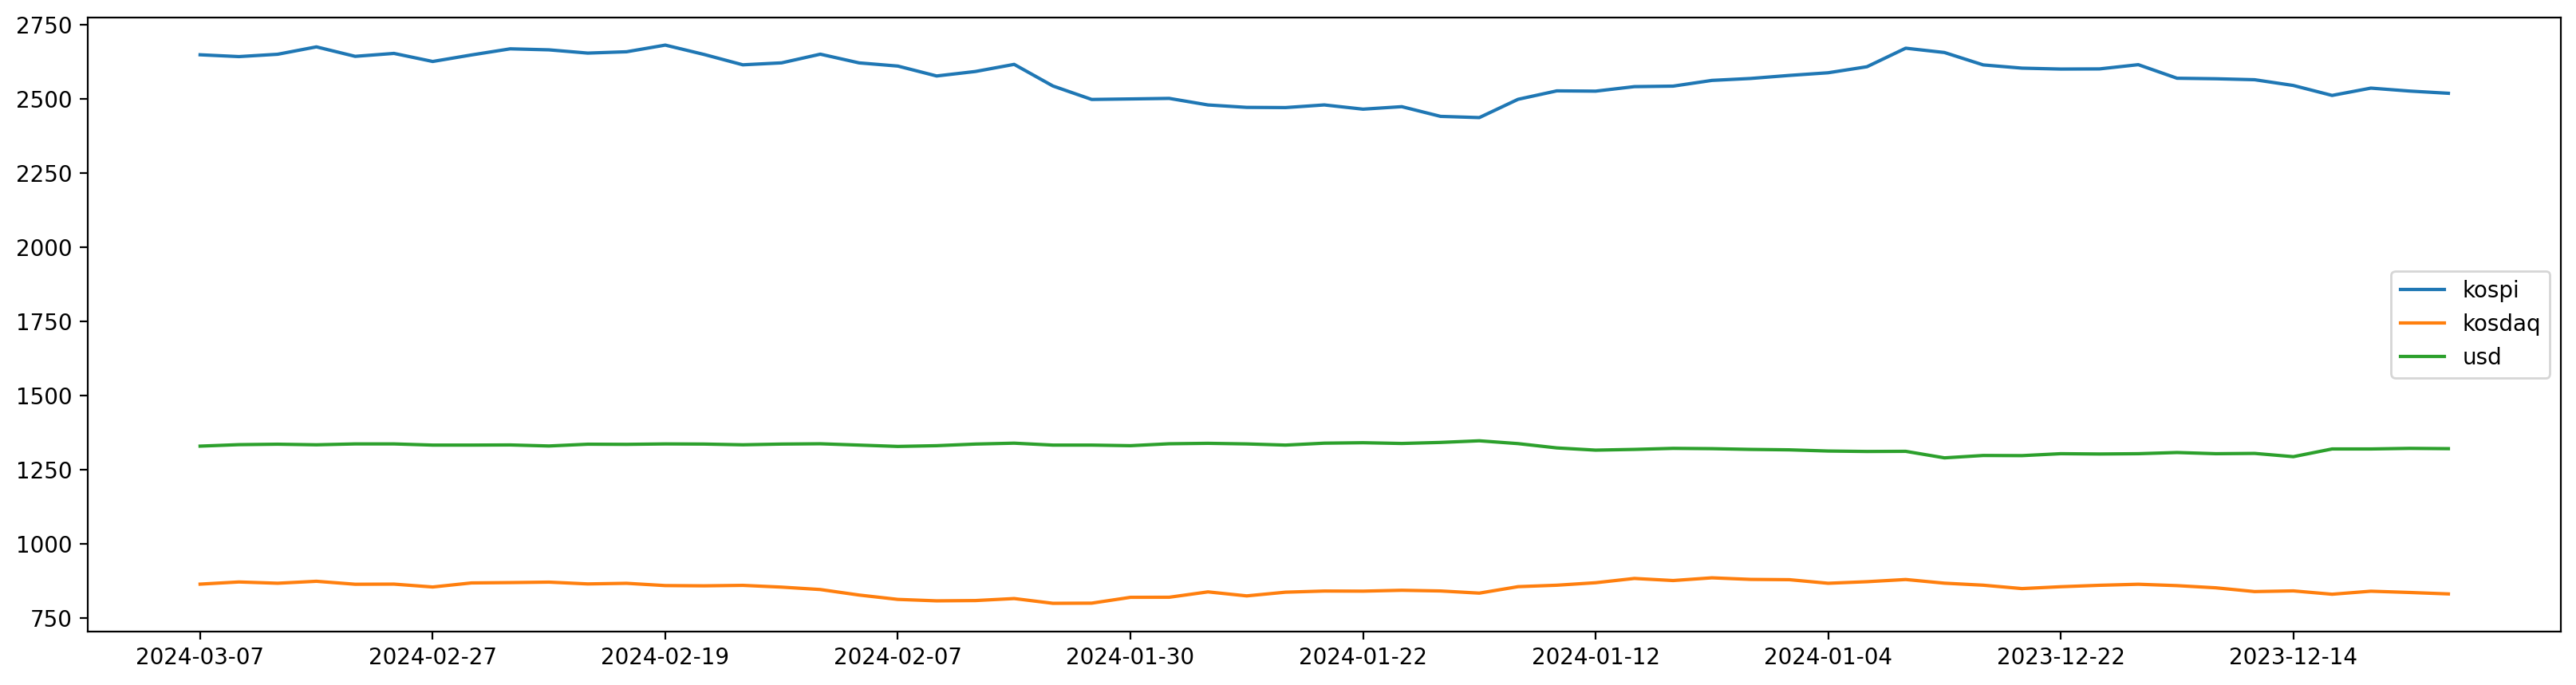

In [40]:
# 시각화
plt.figure(figsize=(20, 5))

columns = merge_df.columns[1:]
for column in columns:
    plt.plot(merge_df['localTradedAt'], merge_df[column], label = column)
xticks_count = 11
plt.xticks(
    merge_df['localTradedAt'][::int(len(merge_df) // xticks_count) + 1]
)
plt.legend(loc=0)
plt.show()

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [41]:
from sklearn.preprocessing import minmax_scale

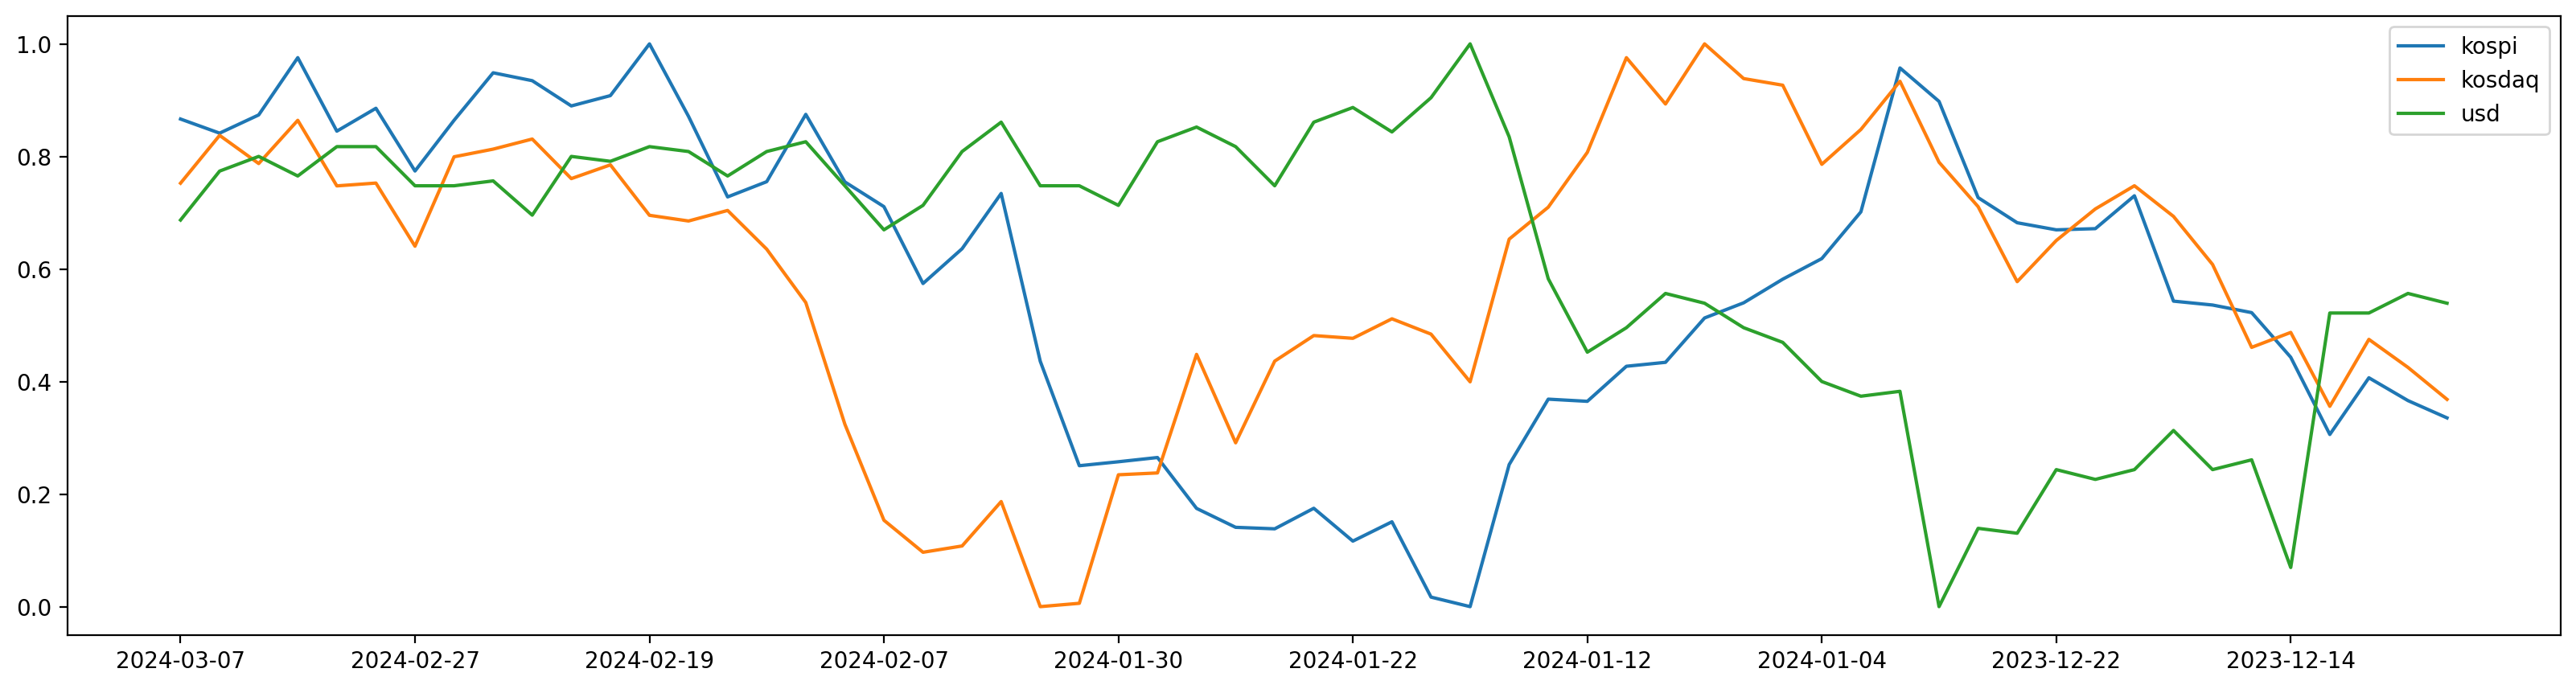

In [43]:
# 시각화
plt.figure(figsize=(20, 5))

columns = merge_df.columns[1:]
for column in columns:
    plt.plot(
        merge_df['localTradedAt'], minmax_scale(merge_df[column]), label=column
    )
xticks_count = 11
plt.xticks(
    merge_df['localTradedAt'][::int(len(merge_df) // xticks_count) + 1]
)
plt.legend(loc=0)
plt.show()

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [44]:
# 해석 1 : kospi, kosdaq은 아주 강한 양의 상관관계를 갖는다. (데이터가 같은 방향으로 움직임)
# 해석 2 : kospi와 usd를 강한 음의 상관관계를 갖는다. (데이터가 반대 방향으로 움직임)
corr_df = merge_df[merge_df.columns[1:]].corr()
corr_df

,kospi,kosdaq,usd
kospi,1.000000,0.463815,-0.148180
kosdaq,0.463815,1.000000,-0.285509
usd,-0.148180,-0.285509,1.000000


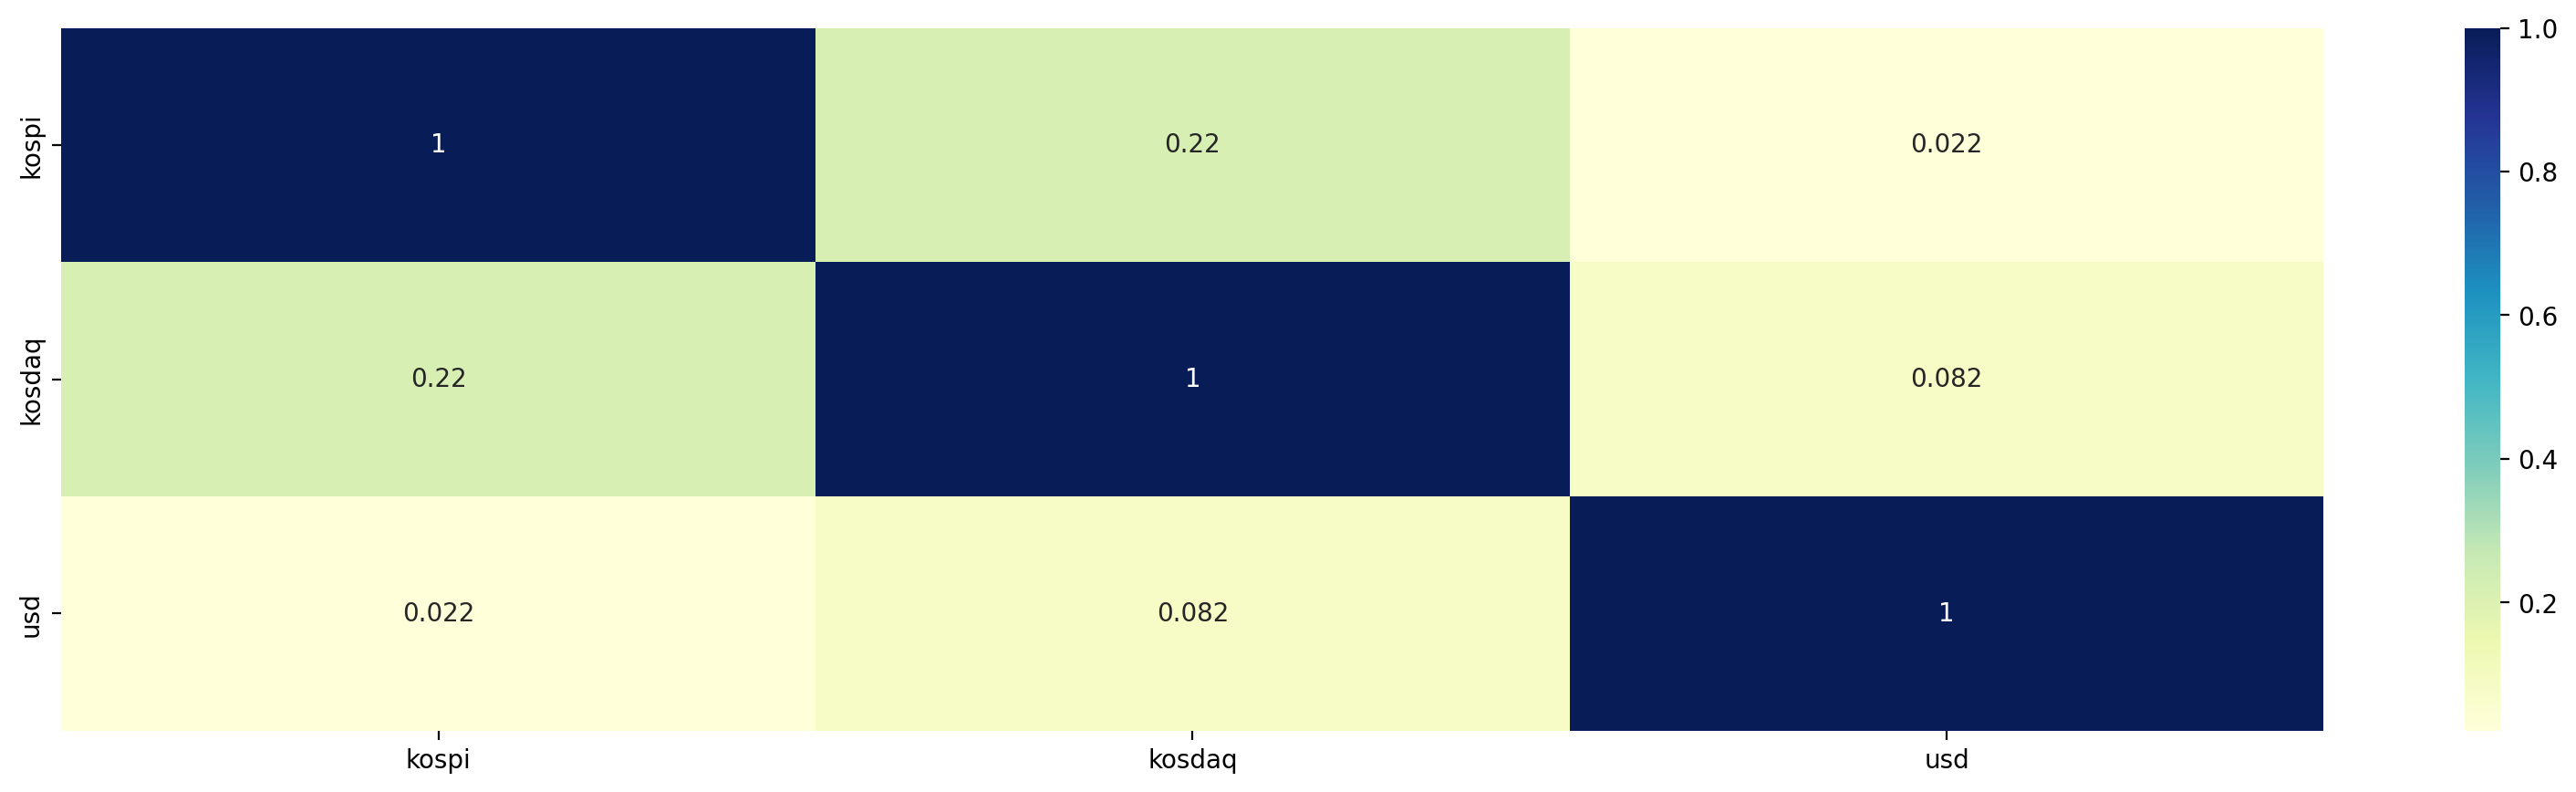

In [46]:
# 결정계수 : r-squared
# 1과 가까울수록 강한 관계, 0과 가까울수록 약한 관계

plt.figure(figsize=(20, 5))
sns.heatmap(corr_df**2, cmap='YlGnBu', annot=True)
plt.show()